In [10]:
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline


# sys.path.append("/path/to/your/project")
from hockey.hockey_env import HockeyEnv_BasicOpponent, Mode

try:
    from models.ddpg.DDPG import DDPGAgent
    from models.ddpg.DDPGTrainer import DDPGTrainer
except ImportError:
    print("Could not import DDPG.")
    raise

In [12]:
# The single-agent wrapper environment is `HockeyEnv_BasicOpponent`.
# By default:
#   - It uses mode=Mode.NORMAL
#   - keep_mode=True
#   - An opponent with `weak_opponent=False` or True
#
# action_space of shape (4,) 
# suitable for a single-agent continuous control algorithms

env = HockeyEnv_BasicOpponent(
    mode=Mode.NORMAL,   # or Mode.TRAIN_SHOOTING, Mode.TRAIN_DEFENSE
    weak_opponent=True # whether the opponent is weaker or not
)

print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

# For reference:
# - The observation space is Box(...) with shape (18,) if keep_mode=True.
# - The action space is Box(...) with shape (4,). 
#   The four actions: 
#       1) Force in x, 
#       2) Force in y, 
#       3) Torque (racket rotation),
#       4) Shoot command (0 or 1).

Observation space: Box(-inf, inf, (18,), float32)
Action space: Box(-1.0, 1.0, (4,), float32)


In [13]:
training_config = {
    "env_mode": Mode.NORMAL,
    "max_episodes": 6000,     
    "max_timesteps": 250,    
    "log_interval": 20,
    "save_interval": 1000,
    "render": False,         
    "train_iter": 32,       
    "seed": 42,
    "epsilon_start": 1.0,   
    "epsilon_min": 0.05,  
    "epsilon_decay": 0.999,               
}

model_config = {
    "eps": 0.0,                  
    "discount": 0.95,      
    "buffer_size": int(1e6),     
    "batch_size": 128,            
    "learning_rate_actor": 1e-4, 
    "learning_rate_critic": 1e-4,
    "hidden_sizes_actor": [256, 256],
    "hidden_sizes_critic": [256, 256],
    "update_target_every": 100,
    "use_target_net": True
}

experiment_path = "rl_experiments/experiments/HockeyEnv_DDPG_Test"

# Initialize trainer
trainer = DDPGTrainer(
    env_name="HockeyEnv",
    training_config=training_config,
    model_config=model_config,
    experiment_path=experiment_path,
    wandb_run=None 
)


2025-01-26 14:53:26 [INFO] Logger initialized. Writing logs to rl_experiments/experiments/HockeyEnv_DDPG_Test/results/training/logs/DDPG_HockeyEnv_eps0.0_alr0.0001_clr0.0001_gamma0.95.log
2025-01-26 14:53:26 [INFO] Initialized random seeds to 42.


In [ ]:
## This is only experimental, not sure if the hypothesis is valid

final_metrics = trainer.train()

print("Training finished.")
print("Final metrics:", final_metrics)

2025-01-26 14:54:18 [INFO] Starting DDPG Training...
2025-01-26 14:54:18 [INFO] Environment: HockeyEnv, max_episodes=6000, max_timesteps=250, train_iter=32
2025-01-26 14:54:21 [INFO] Episode 20	Avg Length: 179.05	Avg Reward: -68.680
2025-01-26 14:54:23 [INFO] Episode 40	Avg Length: 153.50	Avg Reward: -73.778
2025-01-26 14:54:25 [INFO] Episode 60	Avg Length: 149.50	Avg Reward: -61.862
2025-01-26 14:54:27 [INFO] Episode 80	Avg Length: 178.55	Avg Reward: -103.486
2025-01-26 14:54:30 [INFO] Episode 100	Avg Length: 182.10	Avg Reward: -121.292
2025-01-26 14:54:32 [INFO] Episode 120	Avg Length: 184.40	Avg Reward: -126.378
2025-01-26 14:54:35 [INFO] Episode 140	Avg Length: 154.20	Avg Reward: -106.287
2025-01-26 14:54:38 [INFO] Episode 160	Avg Length: 187.10	Avg Reward: -107.522
2025-01-26 14:54:41 [INFO] Episode 180	Avg Length: 177.20	Avg Reward: -135.485
2025-01-26 14:54:44 [INFO] Episode 200	Avg Length: 157.60	Avg Reward: -105.034
2025-01-26 14:54:46 [INFO] Episode 220	Avg Length: 173.55	Avg

In [8]:
# checkpoint_path = "competition/EpsilonGreedy0.999/DDPG_HockeyEnv_eps0_alr0.0001_clr0.0001_gamma0.95_checkpoint_ep10000.pth"

# checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

# # 4) Restore the agent's networks
# trainer.agent.restore_state(checkpoint)

/var/folders/x2/dvcm78hn67g79fdt399dzt8c0000gn/T/ipykernel_10333/2912540979.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_

In [9]:
num_test_episodes = 100
cumulative_rewards = []
win_count = 0
for ep in range(num_test_episodes):
    obs, _ = env.reset()
    done = False
    episode_reward = 0.0
    while not done:
        # set simple deterministic policy
        action = trainer.agent.act(obs, evaluate=True)  
        obs, reward, done, trunc, info = env.step(action)
        episode_reward += reward

        env.render(mode="rgb_array")

        if done or trunc:
            break
    cumulative_rewards.append(episode_reward)
    if info["winner"] == 1:
        win_count += 1

env.close()

print("Average cumulative reward:", np.mean(cumulative_rewards))
print("Win rate:", win_count / num_test_episodes)



Average cumulative reward: -0.09078805173781593
Win rate: 0.29


In [3]:
obs, reward, done, trunc, info = env.step(action)
print("Info:", info)

NameError: name 'action' is not defined

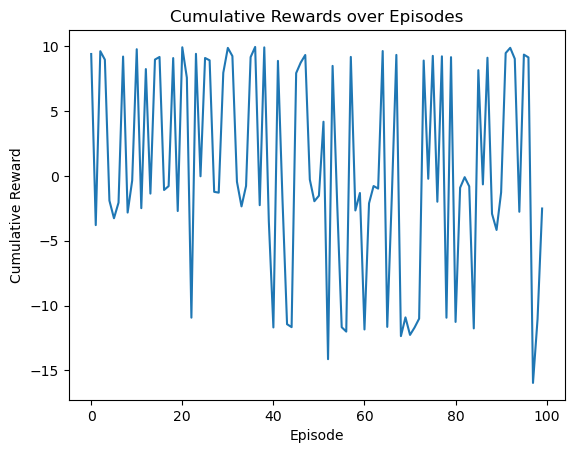

In [29]:
# plot the cumulative rewards
plt.plot(cumulative_rewards)
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Rewards over Episodes")
plt.show()


In [27]:
import imageio
import numpy as np

num_test_episodes = 50

for ep in range(num_test_episodes):
    frames = []
    obs, info = env.reset()
    done = False
    episode_reward = 0.0
    while not done:
        # Act with no noise at test time
        action = trainer.agent.act(obs, evaluate=True)
        obs, reward, done, trunc, info = env.step(action)
        episode_reward += reward

        # ---- Capture frame in rgb_array mode ----
        frame_rgb = env.render(mode='rgb_array')  
        frames.append(frame_rgb)

        if done or trunc:
            break

    env.close()
    print(f"Episode {ep} reward: {episode_reward}", end=" ")
    if info["winner"] == 1:
        print("Won")
    else:
        print("Lost")


    gif_path = f"gifs/ddpg_laserhockey_episode{ep}.gif"
    imageio.mimsave(gif_path, frames, fps=15)

Episode 0 reward: -11.18197643112837 Lost
Episode 1 reward: -2.0936035953171492 Lost
Episode 2 reward: -2.6417888241930885 Lost
Episode 3 reward: 9.130166139463812 Won
Episode 4 reward: -0.5264979229136774 Lost
Episode 5 reward: -4.602747144371341 Lost
Episode 6 reward: -0.8970391983996904 Lost
Episode 7 reward: -1.1528784967866572 Lost
Episode 8 reward: -11.320976419601054 Lost
Episode 9 reward: 9.082944901636724 Won
Episode 10 reward: -10.85384289542985 Lost
Episode 11 reward: 9.440494650161268 Won
Episode 12 reward: 9.804648584854291 Won
Episode 13 reward: 9.47537006212856 Won
Episode 14 reward: 9.978102661183234 Won
Episode 15 reward: -13.382321862926906 Lost
Episode 16 reward: 9.414427687818318 Won
Episode 17 reward: 9.253854228747345 Won
Episode 18 reward: -0.025228092487582524 Lost
Episode 19 reward: 9.934361397930806 Won
Episode 20 reward: -2.399252603863238 Lost
Episode 21 reward: -11.476916945130338 Lost
Episode 22 reward: -1.1175336491663148 Lost
Episode 23 reward: -13.93919

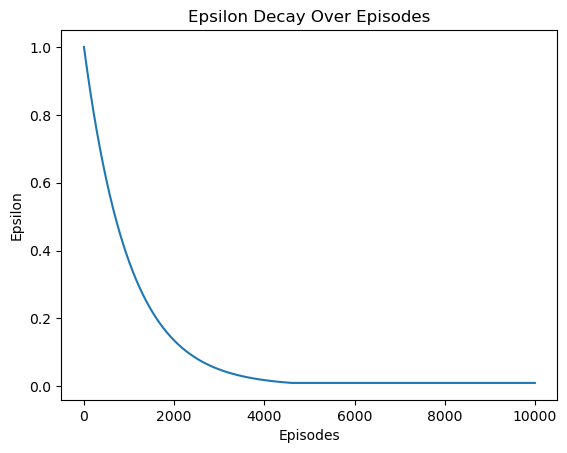

In [23]:
epsilon_start = 1.0  
epsilon_end = 0.01  
epsilon_decay = 0.999
max_episodes=10000
max_steps=500
episodes = np.arange(max_episodes)
epsilon_values = epsilon_start * (epsilon_decay ** episodes)
epsilon_values = np.maximum(epsilon_values, epsilon_end)

plt.plot(episodes, epsilon_values)
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay Over Episodes')
plt.show()

In [12]:

# 4) Save frames as GIF
gif_path = "ddpg_laserhockey_episode.gif"
imageio.mimsave(gif_path, frames, fps=15)  # set fps as desired
print(f"Saved GIF to {gif_path}")

Saved GIF to ddpg_laserhockey_episode.gif


## Further Training on Specialized curriculum

In [ ]:
def run_curriculum():
    # First we train Shooting
    trainer = DDPGTrainer(env_name="HockeyEnv",
                          training_config=training_config,
                          model_config=model_config,
                          experiment_path="path/to/exp",
                          env_mode="train_shooting",
                          weak_opponent=True)
    trainer.train()  # => here we store final checkpoint
    
    # Then we train Defense
    trainer.env.close()
    trainer.env_mode = "train_defense"
    trainer.train()
    
    # Normal Mode (Weak Opponent)
    trainer.env.close()
    trainer.env_mode = "normal"
    trainer.weak_opponent = True
    trainer.train()
    
    # Normal Mode (Strong Opponent)
    trainer.env.close()
    trainer.weak_opponent = False
    trainer.train()
